# การตรวจจับการฉ้อโกงบัตรเครดิต

#### Time : จำนวนวินาทีที่ผ่านไประหว่างธุรกรรม
#### V1 - V28 : คุณสมบัติ V1-V28 เป็นองค์ประกอบหลักที่ได้รับจาก PCA เนื่องจากปัญหาการรักษาความลับ จึงไม่สามารถให้คุณลักษณะดั้งเดิมได้
#### Amount  : จำนวนธุรกรรม 
#### Class : 0 สำหรับการทำธุรกรรมที่เป็นปกติ , 1 สำหรับการทำธุรกรรมที่เป็นการฉ้อโกง

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler , MinMaxScaler , RobustScaler
from sklearn.metrics import *

import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE , RandomOverSampler
from tensorflow.keras.layers import Dense , Dropout , Activation , BatchNormalization
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [3]:
credit = pd.read_csv('creditcard.csv.zip')
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Understanding

#### ตรวจสอบ data เบิ้องต้น

In [4]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

#### ตรวจสอบ Missing values

In [5]:
credit.isna().sum().sum()

0

In [6]:
mask = np.triu(np.ones_like(credit.corr() , dtype=bool))

#### ความสัมพันธ์ของแต่ละคุณสมบัติ

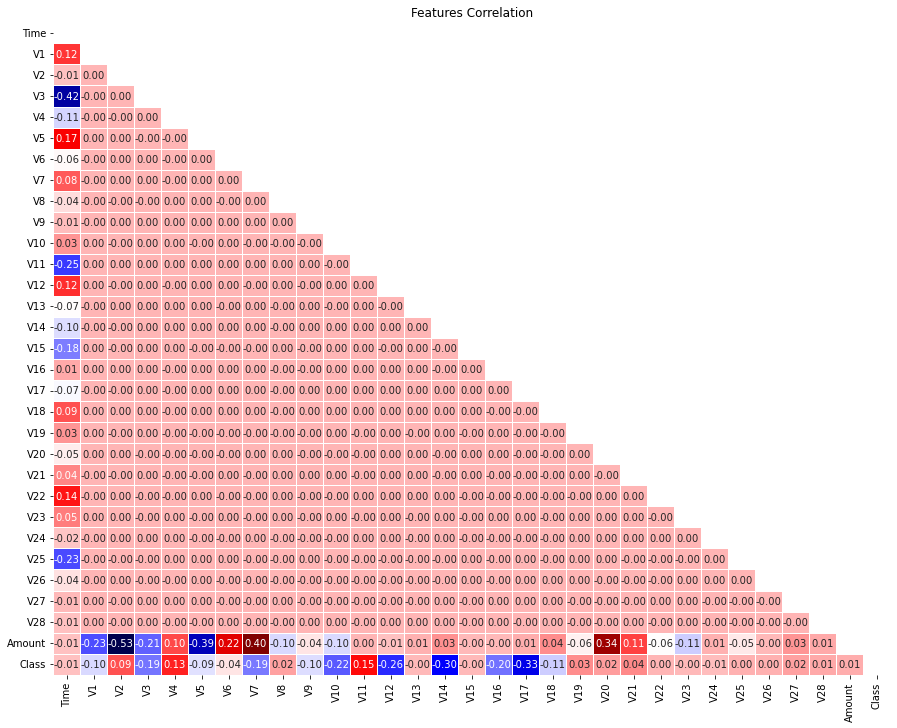

In [7]:
plt.figure(figsize=(15,12))
sns.heatmap(credit.corr() , annot=True , fmt='.2f' , cmap='seismic' , cbar=False , mask=mask , linewidths=1)
plt.title('Features Correlation');

## EDA

In [8]:
plt.style.use('ggplot')

#### จำนวนการทำธุรกรรมปกติ(class=0) กับ จำนวนการทำธุรกรรมที่ฉ้อโกง(class=1)

In [9]:
credit['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

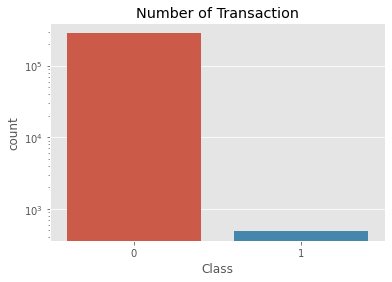

In [10]:
sns.countplot(data=credit , x='Class')
plt.yscale('log')
plt.title('Number of Transaction');

In [11]:
positive_col = credit.corr()['Class'].sort_values()[-6:-1].keys()
negative_col = credit.corr()['Class'].sort_values()[:5].keys()

In [12]:
positive_col

Index(['V19', 'V21', 'V2', 'V4', 'V11'], dtype='object')

In [13]:
negative_col

Index(['V17', 'V14', 'V12', 'V10', 'V16'], dtype='object')

In [14]:
def boxplot(i , col) :
    sns.boxplot(data=credit , x='Class' , y=col , fliersize=False , ax = ax[i])
    ax[i].set_title(col)
    ax[i].set_ylabel('')

#### 5 คุณสมบัติที่มีผลเชิงบวกต่อ Class มากทีสุด

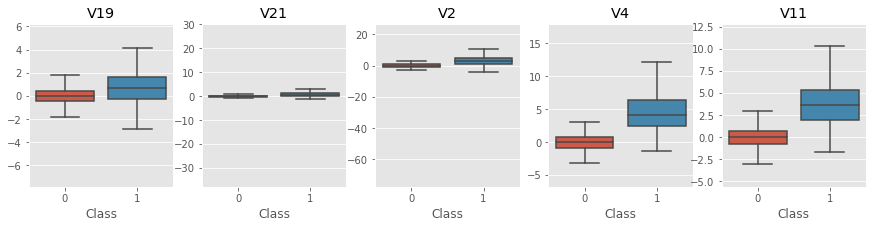

In [15]:
fig , ax = plt.subplots(1,5 , figsize=(15,3))
for i , col  in enumerate(positive_col) :
    boxplot(i , col)

#### 5 คุณสมบัติที่มีผลเชิงลบต่อ Class มากทีสุด

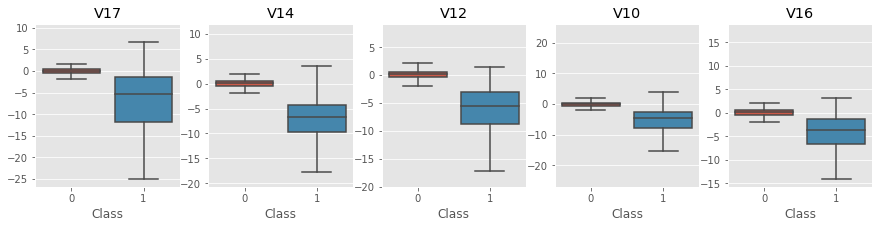

In [16]:
fig , ax = plt.subplots(1,5 , figsize=(15,3))
for i , col  in enumerate(negative_col) :
    boxplot(i , col)

#### การกระจายตัวของ Time(เวลา) ของการทำธุรกรรมที่ฉ้อโกง(class=1)

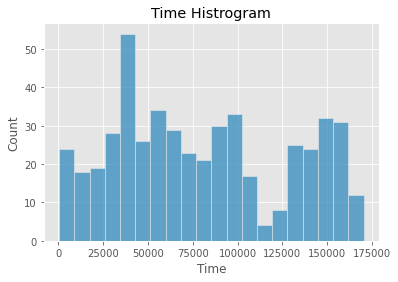

In [17]:
sns.histplot(credit[credit['Class'] == 1 ]['Time'] , bins=20)
plt.title('Time Histrogram');

#### การกระจายตัวของ Amount(จำนวนธุรกรรม) ของการทำธุรกรรมที่ฉ้อโกง(class=1)

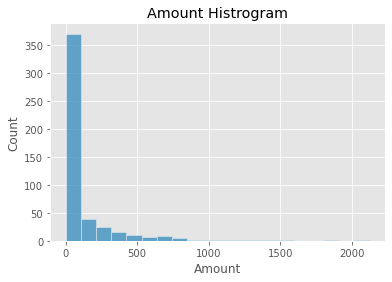

In [18]:
sns.histplot(credit[credit['Class'] == 1 ]['Amount'] , bins=20)
plt.title('Amount Histrogram');

## Data Preparation

#### แบ่ง Feature และ Target

In [19]:
features = credit.drop('Class' , axis=1)
target = credit['Class']

In [20]:
#for col in features.columns:
    #features[col] = scaler.fit_transform(features[[col]])

#### แบ่งชุดข้อมูลสำหรับเรียนรู้และทดสอบ

In [21]:
x_train , x_test , y_train , y_test = train_test_split(features , target ,test_size=0.2 ,shuffle=True , stratify=target)

#### จำนวน sample ของชุดเรียนรู้และชุดทดสอบ

In [22]:
print(x_train.shape)
print(x_test.shape)

(227845, 30)
(56962, 30)


In [23]:
#scaler = MinMaxScaler()
#scaler = StandardScaler()
scaler = RobustScaler()

In [24]:
over_sampling = SMOTE()
#over_sampling = RandomOverSampler()

### Feature scaling

In [26]:
x_train = pd.DataFrame(scaler.fit_transform(x_train) , columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test) , columns=x_test.columns)

#### จำนวน class

In [27]:
y_train.value_counts()

0    227451
1       394
Name: Class, dtype: int64

#### เห็นได้ว่า class=0 และ class=1 มีชุดข้อมูลที่ไม่สมดุล(imbalanced)

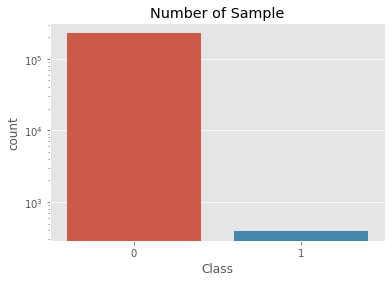

In [28]:
sns.countplot(y_train)
plt.title('Number of Sample')
plt.yscale('log')

#### ทำการปรับข้อมูลโดยเพิ่ม class=1 เพื่อให้ทั้งสอง class มีจำนวนเท่ากัน (Oversampling)

In [29]:
x_train , y_train = over_sampling.fit_resample(x_train , y_train)

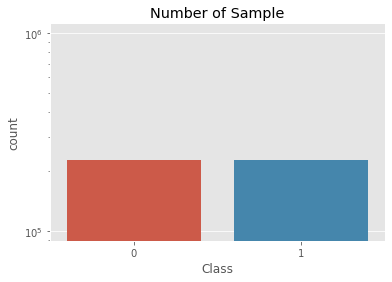

In [30]:
sns.countplot(y_train)
plt.title('Number of Sample')

In [31]:
n_input = x_train.shape[1]
n_input 

30

## Modeling

In [32]:
class DNN(tf.keras.Model) :
    
    def __init__(self) :
        super (DNN , self).__init__()
        
        self.layer_1 = Dense(30 , activation='relu')        
        
        self.layer_2 = Dense(40 , activation='relu')
        self.layer_3 = Dropout(0.33)

        self.classes = Dense(2 , activation='softmax')
    
    def call(self , x) :
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)

    
        return self.classes(x)

In [33]:
model = DNN()

In [34]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
model_his = model.fit(x_train , y_train.values , epochs=20 ,  verbose=2 , 
                       batch_size=300 , validation_split=0.2 )

Epoch 1/20
1214/1214 - 3s - loss: 0.1111 - accuracy: 0.9578 - val_loss: 0.0460 - val_accuracy: 0.9867
Epoch 2/20
1214/1214 - 2s - loss: 0.0306 - accuracy: 0.9902 - val_loss: 0.0175 - val_accuracy: 0.9982
Epoch 3/20
1214/1214 - 3s - loss: 0.0163 - accuracy: 0.9957 - val_loss: 0.0113 - val_accuracy: 0.9992
Epoch 4/20
1214/1214 - 3s - loss: 0.0107 - accuracy: 0.9973 - val_loss: 0.0060 - val_accuracy: 0.9999
Epoch 5/20
1214/1214 - 2s - loss: 0.0080 - accuracy: 0.9981 - val_loss: 0.0037 - val_accuracy: 0.9999
Epoch 6/20
1214/1214 - 3s - loss: 0.0063 - accuracy: 0.9986 - val_loss: 0.0025 - val_accuracy: 0.9999
Epoch 7/20
1214/1214 - 2s - loss: 0.0053 - accuracy: 0.9988 - val_loss: 0.0030 - val_accuracy: 0.9997
Epoch 8/20
1214/1214 - 2s - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 9/20
1214/1214 - 2s - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 10/20
1214/1214 - 2s - loss: 0.0035 - accuracy: 0.9993 - val_loss: 9.2816e-0

In [36]:
model.summary()

Model: "dnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  930       
_________________________________________________________________
dense_1 (Dense)              multiple                  1240      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  82        
Total params: 2,252
Trainable params: 2,252
Non-trainable params: 0
_________________________________________________________________


## Model Evaluation

In [37]:
model.evaluate(x_test , y_test , verbose=1)

1781/1781 [==============================] - 2s 978us/step - loss: 0.0177 - accuracy: 0.9991


[0.01767960749566555, 0.9991397857666016]

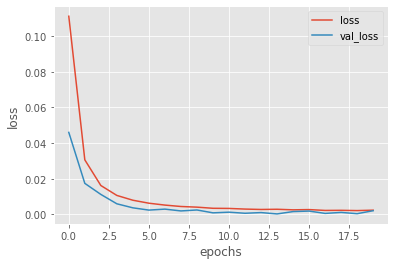

In [38]:
plt.plot(model_his.history['loss'] , label='loss')
plt.plot(model_his.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

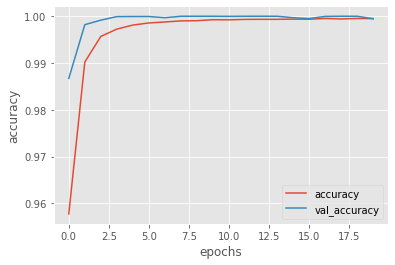

In [39]:
plt.plot(model_his.history['accuracy'] , label='accuracy')
plt.plot(model_his.history['val_accuracy'] , label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();

In [40]:
predict_x = model.predict(x_test)
class_x = np.argmax(predict_x , axis=1)

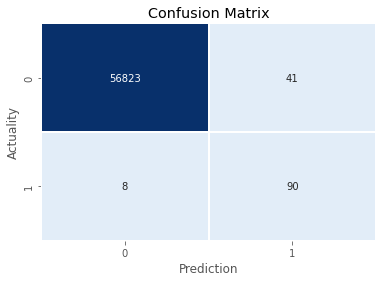

In [41]:
sns.heatmap(confusion_matrix(y_test.values , class_x ) , annot=True , fmt='.0f' , cmap='Blues' , cbar=False , center=25000 , linewidths=2)
plt.xlabel('Prediction')
plt.ylabel('Actuality')
plt.title('Confusion Matrix');

In [42]:
print(classification_report(y_test.values , class_x ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.92      0.79        98

    accuracy                           1.00     56962
   macro avg       0.84      0.96      0.89     56962
weighted avg       1.00      1.00      1.00     56962

